In [3]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Modeling Evaluation
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import os, sys

sys.path.append("../../src")
from helper_functions import MAPE, plot_feature_importances, plot_top5_feature_importances, plot_obs_pred

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sns.set(context = 'notebook', style = 'whitegrid')
ppt_colors = ['#9146ff', '#571dad', '#9168cd', '#bd9eeb', '#b58eee', '#b48bf0']

In [5]:
# Data should be placed in the data/raw folder in order to run the code

raw_data_path = os.path.join(os.pardir, os.pardir, "data", "raw", "twitchdata-update.csv")
df_twitch = pd.read_csv(raw_data_path)

In [6]:
# Let's look at the data

df_twitch.head(5)

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,False,English
1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,False,English
2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,True,Portuguese
3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,False,English
4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,False,English


# Initial EDA

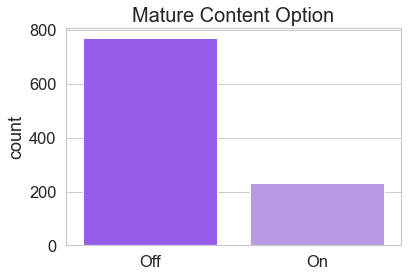

In [7]:
# Mature content or Not

sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1.5)

ax = sns.countplot(x = 'Mature', data = df_twitch, palette = [ppt_colors[0], ppt_colors[4]])
ax.set(xlabel = '', xticklabels = ['Off', 'On'])
ax.set_title('Mature Content Option', fontdict={'fontsize': 20})

#plt.savefig('../../reports/figures/Mature.png', dpi = 500, bbox_inches = 'tight', transparent = True)
plt.show()

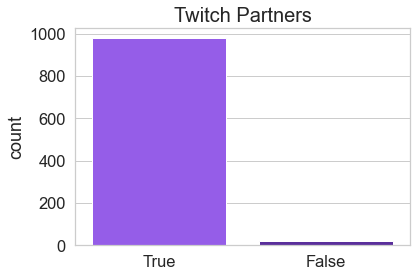

In [8]:
# Partnered or Not

sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1.5)

ax = sns.countplot(x = 'Partnered', data = df_twitch, palette = [ppt_colors[0], ppt_colors[1]], order = df_twitch['Partnered'].value_counts().index)
ax.set(xlabel = '', xticklabels = ['True', 'False'])
ax.set_title('Twitch Partners', fontdict={'fontsize': 20})

#plt.savefig('../../reports/figures/Partnered.png', dpi = 500, bbox_inches = 'tight', transparent = True)
plt.show()

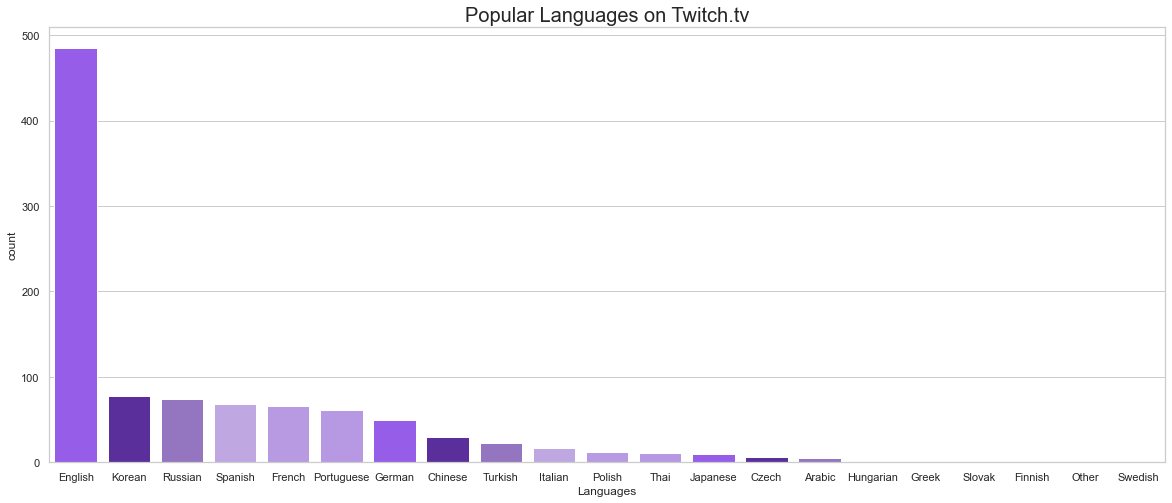

In [9]:
# Language breakdown
plt.figure(figsize=(20, 8))
sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1)
xlabel = 'Languages'
ylabel = 'count'

ax = sns.countplot(x = 'Language', data = df_twitch, order = df_twitch['Language'].value_counts().index, palette = ppt_colors)
ax.set(xlabel = xlabel, ylabel = ylabel)
ax.set_title('Popular Languages on Twitch.tv', fontdict={'fontsize': 20})

#plt.savefig('../../reports/figures/Languages.png', dpi = 500, bbox_inches = 'tight', transparent = True)
plt.show()

In [10]:
# Label Encoding Partnered column True : 1, False : 0 

Partnered_le = df_twitch.Partnered

le = LabelEncoder()
le.fit(Partnered_le)
df_twitch.Partnered = le.transform(Partnered_le)

In [11]:
# Label Encoding Mature column True : 1, False : 0 

Mature_le = df_twitch.Mature

le = LabelEncoder()
le.fit(Mature_le)
df_twitch.Mature = le.transform(Mature_le)

In [12]:
# Label Encoding Language column, numbers assigned to languages by default.

Language_le = df_twitch.Language

le = LabelEncoder()
le.fit(Language_le)
df_twitch.Language = le.transform(Language_le)

In [13]:
# Set a channel name as an index

df_twitch.set_index('Channel', drop=True, inplace=True)
df_twitch.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
Channel,,,,,,,,,,
xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,1,0,3
summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,1,0,3
Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,1,1,14
ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,1,0,3
Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,1,0,3


In [14]:
# Dropping channels that didn't gain followers
df_twitch_drop = df_twitch[df_twitch['Followers gained'] < 0].index
df_twitch_drop

Index(['Amaz', 'TSM_TheOddOne', '마스카 (newmasca)'], dtype='object', name='Channel')

In [15]:
df_twitch = df_twitch.drop(df_twitch_drop)

In [16]:
# clean data

df_twitch.to_csv('../../data/clean/CleanData.csv')

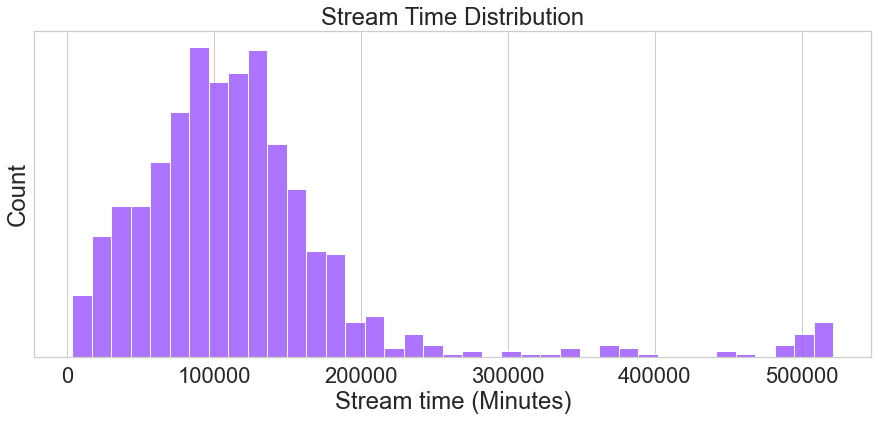

In [256]:
# Plot Target Distribution

plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale = 2.0)

target_dist = sns.histplot(df_twitch['Stream time(minutes)'], color = "#9146ff")
target_dist.set(xlabel='Stream time (Minutes)', title='Stream Time Distribution', yticks=[])

#plt.savefig("../../reports/figures/Stream_time_dist.png", bbox_inches='tight', dpi=500)
plt.show()

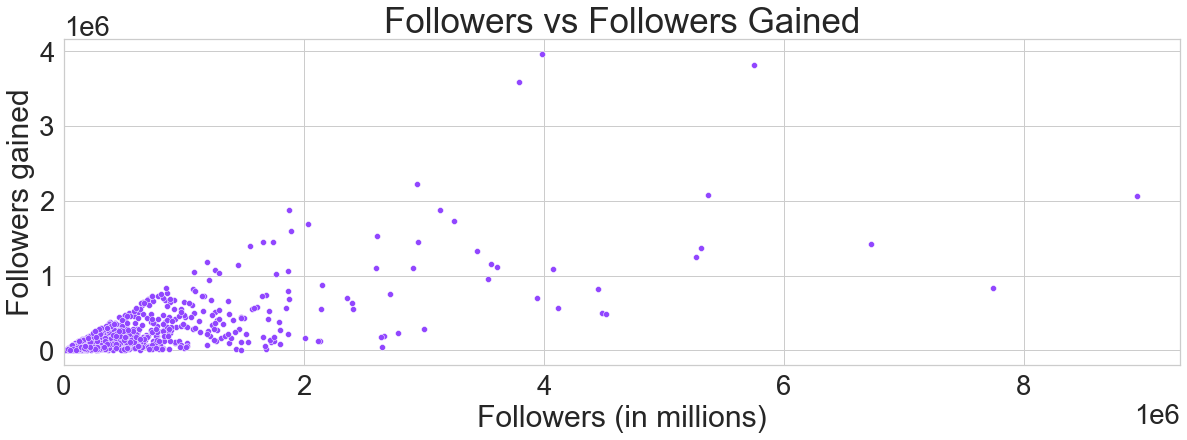

In [257]:
# Scatter plot
plt.figure(figsize=(20, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale = 2.5)

line = sns.scatterplot(x='Followers', y='Followers gained', data=df_twitch,  color = "#9146ff")
line.set(xlabel='Followers (in millions)', ylabel='Followers gained')
line.set_title('Followers vs Followers Gained', fontdict={'fontsize': 35})
plt.xlim(left=0, right=9.3e6)

#plt.savefig("../../reports/figures/FollowersvsFollowersgained.png", bbox_inches='tight', dpi=500)

Text(0.5, 1.0, 'Peak viewers vs Followers Gained')

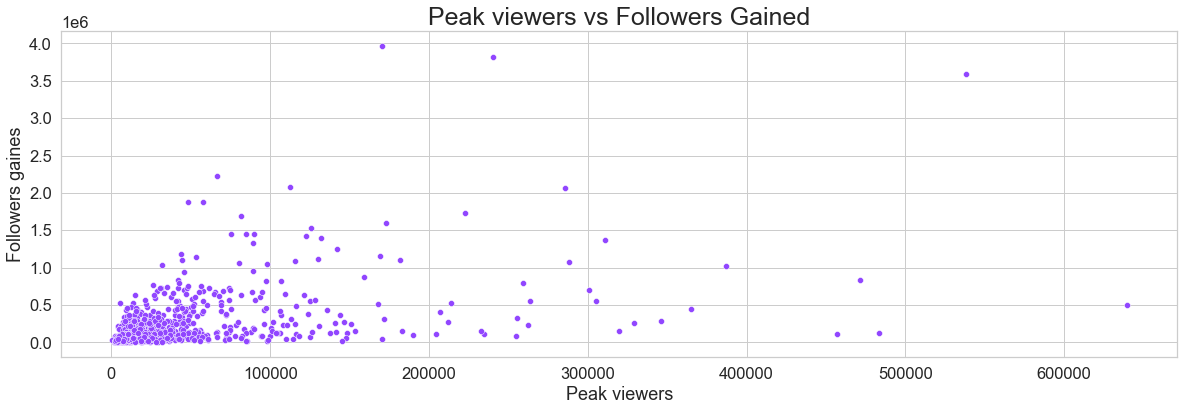

In [227]:
# Scatter plot
plt.figure(figsize=(20, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1.5)

ax = sns.scatterplot(x='Peak viewers', y='Followers gained', data=df_twitch,  color = "#9146ff")
ax.set(xlabel='Peak viewers', ylabel='Followers gaines')
ax.set_title('Peak viewers vs Followers Gained', fontdict={'fontsize': 25})

# Data Preprocessing 

In [20]:
# Separating target y from features X

X = df_twitch.drop(['Followers gained'], axis=1)
y = df_twitch['Followers gained']

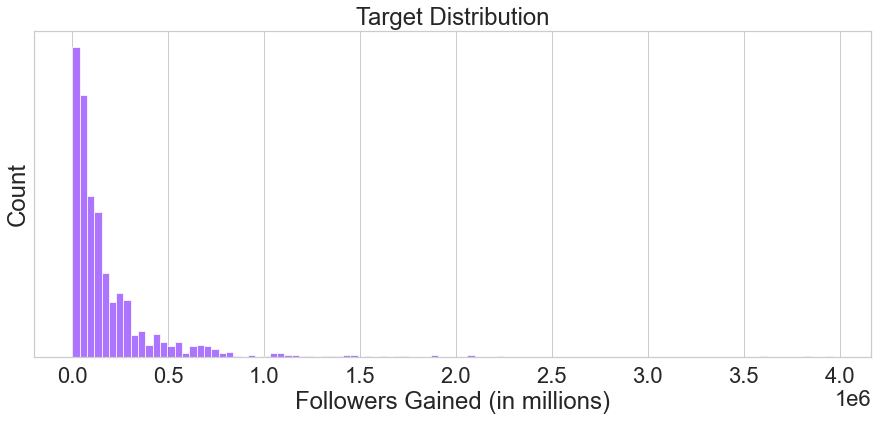

In [226]:
# Plot Target Distribution

plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale = 2.0)

target_dist = sns.histplot(y, color = "#9146ff")
target_dist.set(xlabel='Followers Gained (in millions)', title='Target Distribution', yticks=[])

#plt.savefig("../../reports/figures/Target_Dist.png", bbox_inches='tight', dpi=500)
plt.show()

In [22]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)


In [23]:
# Creating data frames for plotting final model performances

df_train = X_train.merge(y_train, on='Channel')
df_test = X_test.merge(y_test, on='Channel')

In [24]:
# Standard Scaling for Poisson Regressor
ss = StandardScaler()
ss.fit(X_train)
X_t_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# FSM: Linear Regression

Linear Regression Model as First Simple Model

In [25]:
# Create linear regression object
fsm = LinearRegression()

# Train the model using the training set
fsm.fit(X_train, y_train)

LinearRegression()

In [26]:
# Make predictions using the training set
y_pred_lr = fsm.predict(X_train)

In [27]:
# Cross-validation on the training set
scores = cross_val_score(fsm, X_train, y_train, cv=5)
scores

array([0.37159931, 0.4809017 , 0.3453753 , 0.5731573 , 0.57942921])

FSM scores for the test data

In [28]:
# Make predictions using the testing set
y_pred_lr = fsm.predict(X_test)

In [29]:
# The mean absolut percentage error
print('Mean absolute percentage error: %.2f'
      % MAPE(y_test, y_pred_lr))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %3f'
      % r2_score(y_test, y_pred_lr))

Mean absolute percentage error: 156.25
Coefficient of determination: 0.384980


In [75]:
fsm.coef_

array([ 5.14215073e-05, -2.64374637e-01, -1.49854044e-01,  5.10111539e+00,
        2.84417303e-01,  4.37041452e-05, -1.54308836e+04,  4.66705094e+03,
        9.35155183e+03])

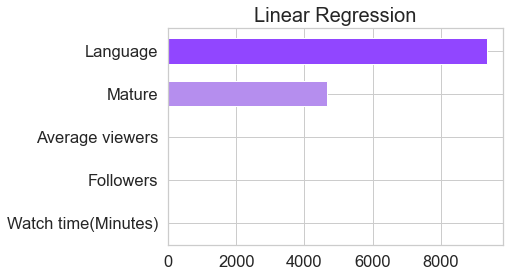

In [76]:
plot_top5_feature_importances(fsm, X_test, 'Linear Regression')

### Random Forest 

Let's run Random Forest and hypertune parameters using Grid Search method

In [30]:
rfr = RandomForestRegressor(random_state=42)

In [31]:
# Define the parameter grid
# n_estimators - number of trees in the forest
# max_features - max number of features considered for splitting a node
# max_depth - max number of levels in each decision tree
# min_samples_leaf - min number of data points allowed in a leaf node

grid = {
    'n_estimators': [100, 1000],
    'max_features': ["auto", "sqrt", "log2"],
    'max_depth': [None, 3, 5, 10, 25],
    'min_samples_leaf': [1, 5, 10]
    
}

In [32]:
# Initialize the gridsearch object with three-fold cross-validation
gs = GridSearchCV(rfr, grid, cv=3)

In [33]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 3, 5, 10, 25],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [100, 1000]})

In [34]:
gs.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'n_estimators': 1000}

In [35]:
gs.best_score_

0.49163939825314534

In [36]:
# Final Random Forest model with best parameters 
rfr_final = RandomForestRegressor(n_estimators=gs.best_params_['n_estimators'], min_samples_leaf=gs.best_params_['min_samples_leaf'], random_state=42, max_features=gs.best_params_['max_features'], max_depth=gs.best_params_['max_depth']) 

In [37]:
rfr_final.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=5,
                      n_estimators=1000, random_state=42)

In [38]:
y_pred_rf = rfr_final.predict(X_train)

In [39]:
# Cross-validation on the training set
scores = cross_val_score(rfr, X_train, y_train, cv=5).mean()
scores

0.5367127529428227

In [40]:
y_pred_rf = rfr_final.predict(X_test)

In [41]:
print('Mean absolute percentage error: %.2f'
      % MAPE(y_test, y_pred_rf))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %2f'
      % r2_score(y_test, y_pred_rf))

Mean absolute percentage error: 132.81
Coefficient of determination: 0.570538


In [70]:
type(rfr_final)

sklearn.ensemble._forest.RandomForestRegressor

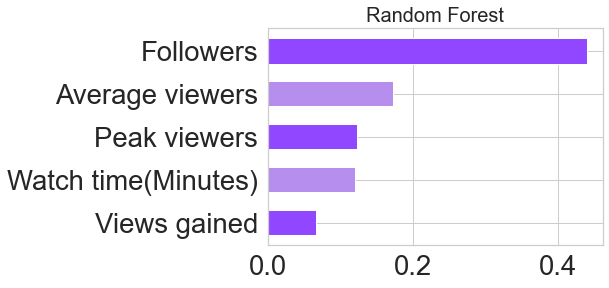

In [259]:
plot_top5_feature_importances(rfr_final, X_test, 'Random Forest')

plt.savefig("../../reports/figures/RF_5_feature_importances.png", bbox_inches='tight', dpi=400)

### Poisson Regressor

The data falls on Poisson distribution and meet all the requirements. The target is a random number of a gained followers over given period of time.  

In [43]:
pr = PoissonRegressor(max_iter=1000)

In [44]:
pr.fit(X_t_ss, y_train)

PoissonRegressor(max_iter=1000)

In [45]:
# Cross-validation
scores = cross_val_score(pr, X_t_ss, y_train, cv=5)
scores

array([ 0.34131693,  0.42767562,  0.37369452, -0.15536657,  0.6991641 ])

In [46]:
y_pred_pr = pr.predict(X_test_ss)

In [47]:
print('Mean absolute percentage error: %.2f'
      % MAPE(y_test, y_pred_pr))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %2f'
      % r2_score(y_test, y_pred_pr))

Mean absolute percentage error: 219.30
Coefficient of determination: 0.214750


In [73]:
pr.coef_

array([ 0.15026807, -0.38986385, -0.01325535,  0.06093903,  0.27439457,
        0.01323543,  0.01833772, -0.0399883 ,  0.18634403])

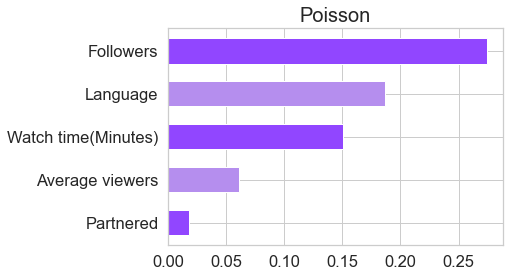

In [74]:
plot_top5_feature_importances(pr, X_test, 'Poisson')

### K-Nearest Neighbors Regressor

Let's try KNN, it should perform well for a small data set.

In [48]:
knn = KNeighborsRegressor()

In [49]:
# Define the parameter grid
grid_knn = {
    'n_neighbors': [5, 10, 25, 50],
    'weights': ["uniform", "distance"],
    'leaf_size': [1, 5, 10]
    
}

In [50]:
# Initialize the gridsearch object with three-fold cross-validation
gs_knn = GridSearchCV(knn, grid_knn, cv=3)

In [51]:
gs_knn.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [1, 5, 10],
                         'n_neighbors': [5, 10, 25, 50],
                         'weights': ['uniform', 'distance']})

In [52]:
gs_knn.best_params_

{'leaf_size': 1, 'n_neighbors': 50, 'weights': 'uniform'}

In [53]:
gs_knn.best_score_

0.16448431144008224

In [84]:
knn_final = KNeighborsRegressor(n_neighbors=50, weights='uniform', leaf_size=1)

In [85]:
knn_final.fit(X_train, y_train)

KNeighborsRegressor(leaf_size=1, n_neighbors=50)

In [86]:
# Cross-validation
scores = cross_val_score(knn_final, X_train, y_train, cv=5)
scores

array([0.21736191, 0.25882061, 0.03311181, 0.29754562, 0.19094661])

In [87]:
y_pred_knn = knn_final.predict(X_test)

In [88]:
print('Mean absolute percentage error: %.2f'
      % MAPE(y_test, y_pred_knn))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %2f'
      % r2_score(y_test, y_pred_knn))

Mean absolute percentage error: 302.62
Coefficient of determination: 0.200084


### Plotting Final Results

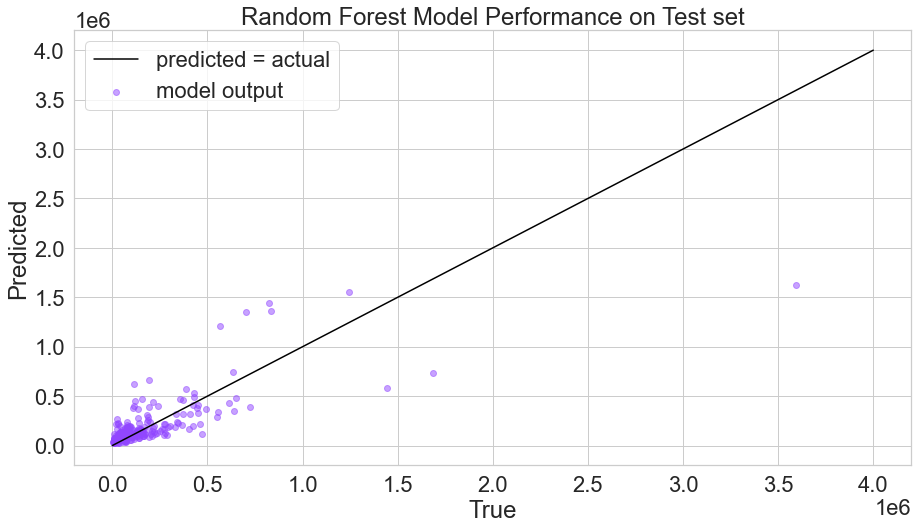

In [255]:
fig, ax = plt.subplots(figsize=(15, 8))

# Customize which model is actually being plotted
ax.set_title("Random Forest Model Performance on Test set")
ax.scatter(y_test, rfr_final.predict(X_test),
                alpha=0.5, label="model output", color=ppt_colors[0])

# Same setup for both plots (x and y labels, line showing y=x)
y_equals_x = np.linspace(0, 4e6)

ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.plot(y_equals_x, y_equals_x, label="predicted = actual", color="black")
ax.legend()

#plt.savefig("../../reports/figures/Models_performances_1.png", bbox_inches='tight', dpi=400)

plt.show()

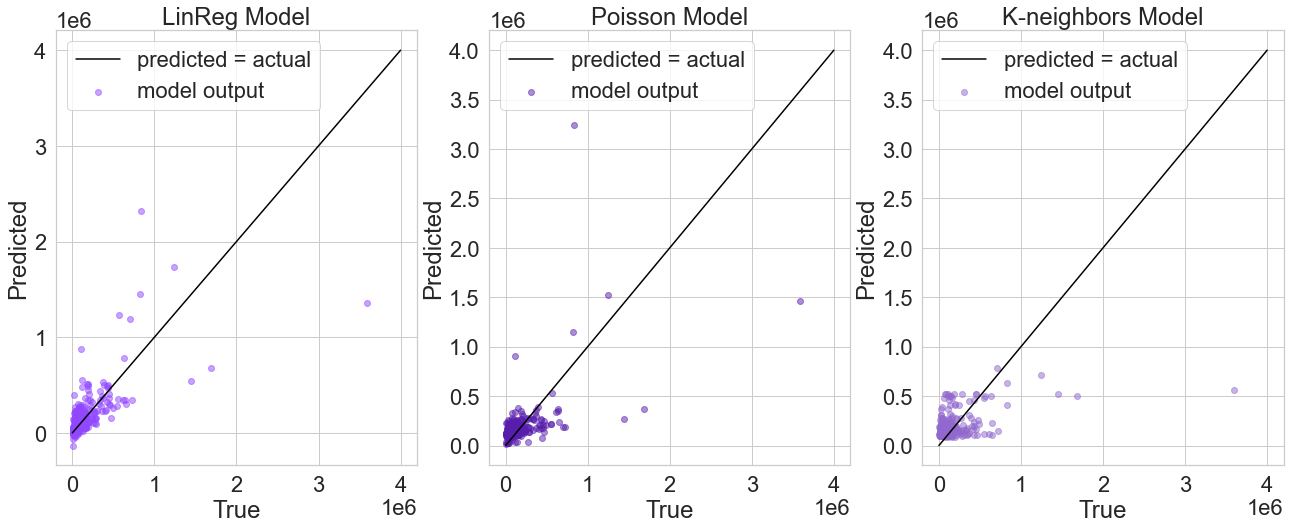

In [253]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(22, 8))

# Customize which model is actually being plotted
ax1.set_title("LinReg Model")
ax1.scatter(y_test, fsm.predict(X_test),
                alpha=0.5, label="model output", color=ppt_colors[0])

ax2.set_title("Poisson Model")
ax2.scatter(y_test, pr.predict(X_test_ss),
                alpha=0.5, label="model output", color=ppt_colors[1])

ax3.set_title("K-neighbors Model")
ax3.scatter(y_test, gs_knn.predict(X_test),
                alpha=0.5, label="model output", color=ppt_colors[2])

# Same setup for both plots (x and y labels, line showing y=x)
y_equals_x = np.linspace(0, 4e6)
for ax in (ax1, ax2, ax3):
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.plot(y_equals_x, y_equals_x, label="predicted = actual", color="black")
    ax.legend()

#plt.savefig("../../reports/figures/Models_performances_2.png", bbox_inches='tight', dpi=400)

##### Final Model Performances

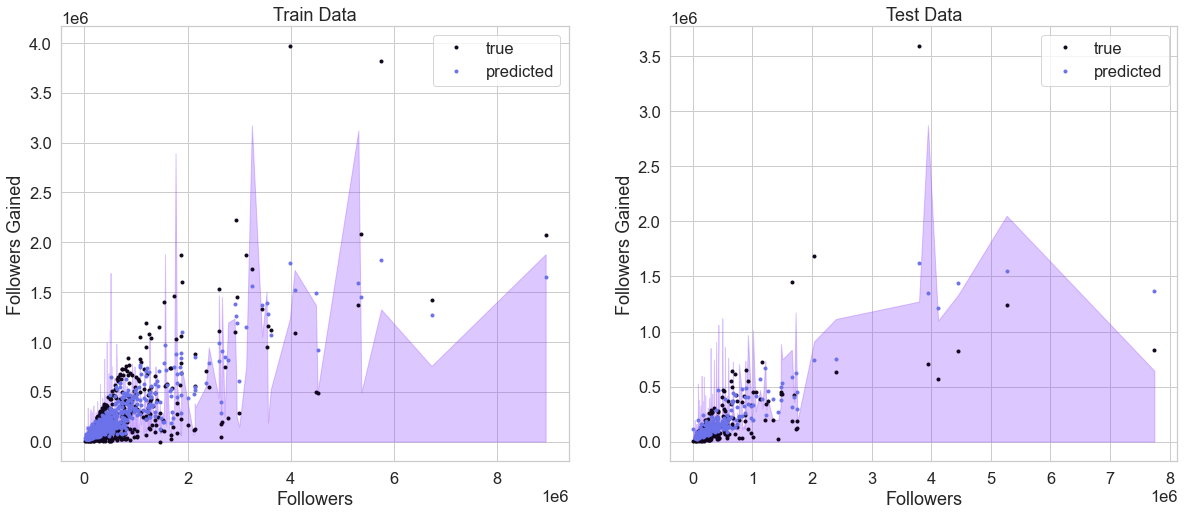

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(
    df=df_train,
    feature="Followers",
    weight="Watch time(Minutes)",
    true="Followers gained",
    predicted=rfr_final.predict(X_train),
    y_label="Followers Gained",
    title="Train Data",
    ax=ax[0],
   
)

plot_obs_pred(
    df=df_test,
    feature="Followers",
    weight="Watch time(Minutes)",
    true="Followers gained",
    predicted=rfr_final.predict(X_test),
    y_label="Followers Gained",
    title="Test Data",
    ax=ax[1],
    
)

#plt.savefig("../../reports/figures/Random_Forest_performances_1.png", bbox_inches='tight', dpi=400)
plt.show()

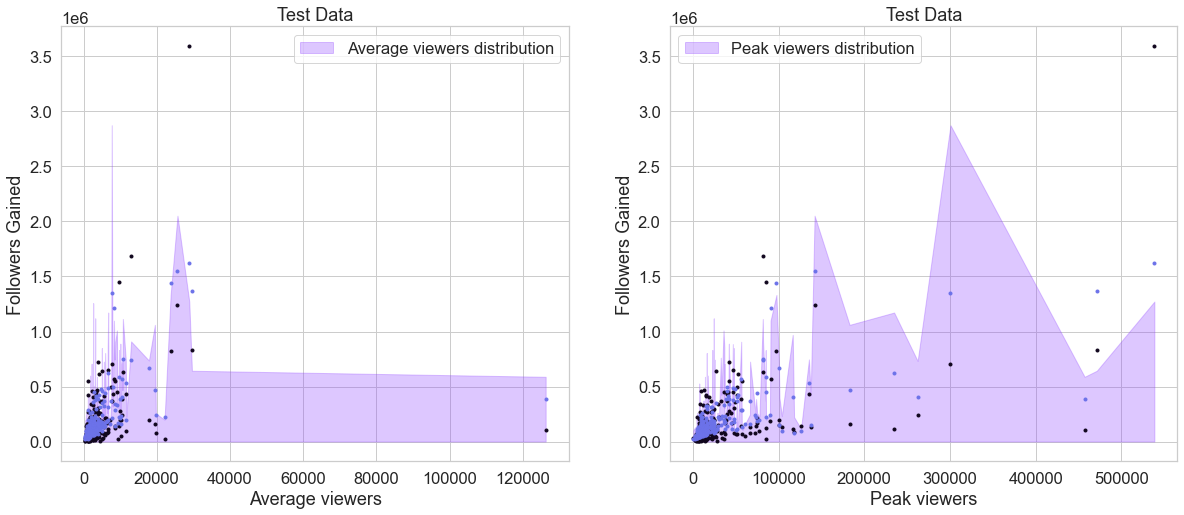

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(
    df=df_test,
    feature="Average viewers",
    weight="Watch time(Minutes)",
    true="Followers gained",
    predicted=rfr_final.predict(X_test),
    y_label="Followers Gained",
    title="Test Data",
    ax=ax[0],
    fill_legend=True
)

plot_obs_pred(
    df=df_test,
    feature="Peak viewers",
    weight="Watch time(Minutes)",
    true="Followers gained",
    predicted=rfr_final.predict(X_test),
    y_label="Followers Gained",
    title="Test Data",
    ax=ax[1],
    fill_legend=True
)

#plt.savefig("../../reports/figures/Random_Forest_performances_2.png", bbox_inches='tight', dpi=400)
plt.show()

### Summary

Random Forest performed the best out of all my models with coefficient of determination: 60%. 
60% of the test data fit the regression model.